Procedure of Importing Data set From Kaggle
Original link: https://www.kaggle.com/discussions/general/74235

Process:
1.   Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens
2.   Click on Create New API Token - It will download kaggle.json file on your machine
3. Go to your Google Colab project file and run the following commands:
*   ! pip install -q kaggle
*   from google.colab import files
* files.upload()
* Choose the kaggle.json file that you downloaded
* ! mkdir ~/.kaggle
* ! cp kaggle.json ~/.kaggle/
* Make directory named kaggle and copy kaggle.json file there


In [ ]:
# Installing kaggle json file for importing the data set
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
 99% 1.74G/1.76G [00:10<00:00, 295MB/s]
100% 1.76G/1.76G [00:10<00:00, 185MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/lung-and-colon-cancer-histopathological-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# Creating directory
DATA_DIR = '/content/lung_colon_image_set/lung_image_sets' # Base directory
CATEGORIES = ['lung_aca', 'lung_n', 'lung_scc']


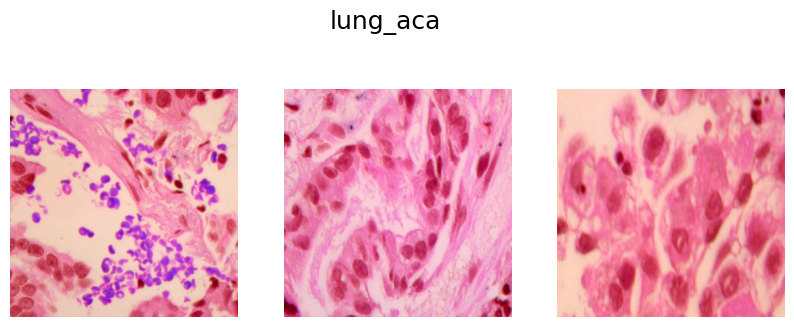

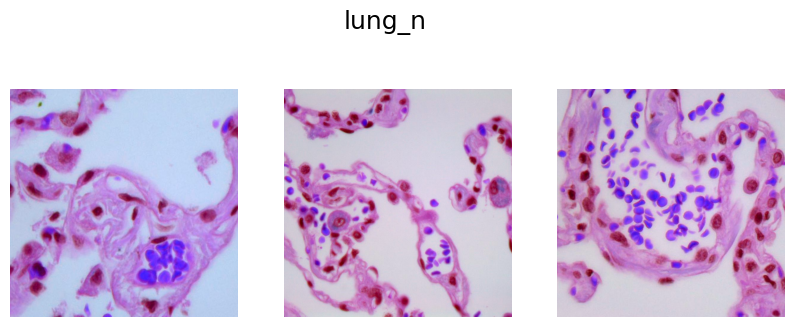

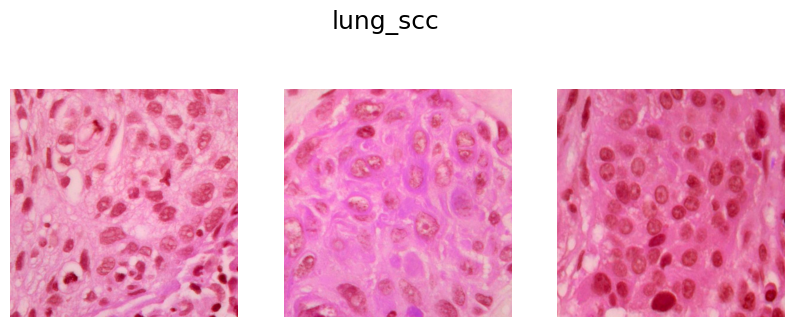

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Creating a Function
for category in CATEGORIES:
  path = os.path.join(DATA_DIR, category)
  images = os.listdir(path)

  fig, ax = plt.subplots(1, 3, figsize = (10,4))
  fig.suptitle(f'{category}', fontsize = 18)

  for i in range(3):
    img_name = images[np.random.randint(0, len(images))]
    img_path = os.path.join(path, img_name)
    img_array = cv2.imread(img_path)

    ax[i].imshow(img_array)
    ax[i].axis('off')


In [ ]:
# Checking the image resolution
img_array.shape

(768, 768, 3)

In [ ]:
# The images require reshaping according to pretrained model VGG16
# Provide the desired size
IMAGE_SIZE = 224

# Resize the image
new_array = cv2.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))


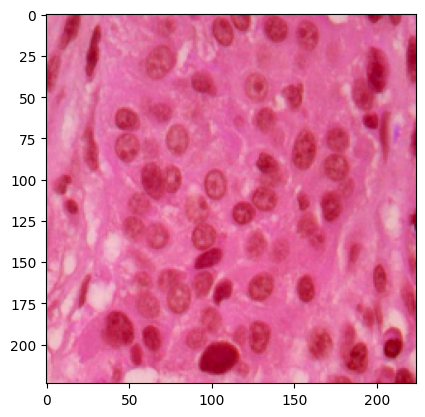

In [ ]:
# Viewing the first image for clarification
plt.imshow(new_array)

In [ ]:
# Creating training data
training_data = []

def create_train_data():
  for category in CATEGORIES:
    path = os.path.join(DATA_DIR, category)
    labels = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))
        training_data.append([new_array, labels])
      except Exception as e:
        pass

create_train_data()

In [ ]:
# Checking the length of training data
len(training_data)

15000

In [ ]:
X = []
y = []

for features, labels in training_data:
  X.append(features)
  y.append(labels)

In [ ]:
type(X), type(y)

(list, list)

In [ ]:
X = np.array(X).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
y = np.array(y)

In [ ]:
type(X), type(y)

(numpy.ndarray, numpy.ndarray)

In [ ]:
# Splitting the data set into train and test data set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [ ]:
# Printing information about training and testing data set

print(f'X_train Length: {X_train.shape[0]}, X_train Image Size: {X_train.shape[1:3]}, X_train Channel Dimension: {X_train.shape[3]}')

print(f'X_test Length: {X_test.shape[0]}, X_test Image Size: {X_test.shape[1:3]}, X_test Channel Dimension: {X_test.shape[3]}')


X_train Length: 12000, X_train Image Size: (224, 224), X_train Channel Dimension: 3
X_test Length: 3000, X_test Image Size: (224, 224), X_test Channel Dimension: 3


In [ ]:
# VGG Model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16

In [ ]:
vgg = VGG16(weights = 'imagenet', include_top = False, input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freezing the pretrained layers
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
# Adding top layers
model = keras.Sequential((
    vgg,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(3, activation = 'softmax')
))

In [ ]:
# Compiling model
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Fitting the data into the model
model.fit(X_train, y_train, epochs =5)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 120ms/step - accuracy: 0.9046 - loss: 0.6091
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 131ms/step - accuracy: 0.9752 - loss: 0.0633
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 84s 136ms/step - accuracy: 0.9841 - loss: 0.0436
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 135ms/step - accuracy: 0.9853 - loss: 0.0370
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 135ms/step - accuracy: 0.9828 - loss: 0.0487


In [ ]:
# Accuracy of the model

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy*100}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 264ms/step - accuracy: 0.9762 - loss: 0.0813
Model Accuracy: 97.43333458900452


In [ ]:
pred = np.argmax(model.predict(X_test), axis = 1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step


In [ ]:
# Printing the predictions of model here O, 1, 2 means the thress types of lung situation (features) provided
# 0 = Adenocarcinoma infected lung
# 1 = Normal lung
# 2 = Squamous cell carcinoma lung
pred

array([2, 1, 2, ..., 2, 2, 2])

In [ ]:
# Printing the first 5 cancer types of the test data
y_test[:5]

array([2, 1, 2, 0, 1])

In [ ]:
# Printing the first 5 cancer types of the model prediction
pred[:5]

array([2, 1, 2, 0, 1])

In [ ]:
# Printing the classification report of the model
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1037
           1       1.00      1.00      1.00       970
           2       0.98      0.94      0.96       993

    accuracy                           0.97      3000
   macro avg       0.98      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



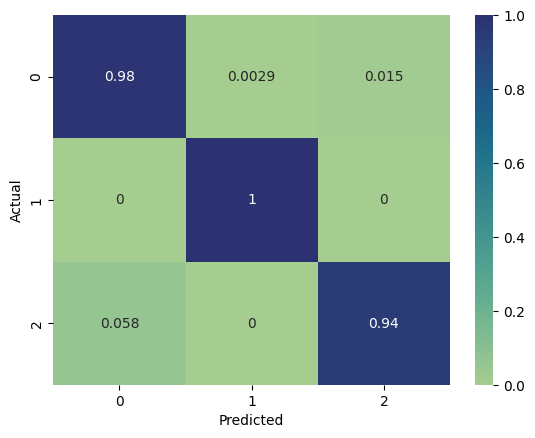

In [ ]:
# Plotting the confusion matrix
cf = confusion_matrix(y_test, pred, normalize='true')
import seaborn as sns
sns.heatmap(cf, annot = True, cmap = 'crest')
plt.xlabel('Predicted');
plt.ylabel('Actual');